# Trabajo práctico nro 1 de AA2.

**Krabbe Valentina Micaela Zoe.**


Resolver las consignas comentando el código fuente, indicando desde dónde fue extraido o generado.

Justificar cada paso realizado.

Publique enlace público a su notebook en google colab y también enlace a su repositorio github de la materia.








# Carga de librerías

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms


## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


In [2]:
# prompt: usar pytorch para crear una clase que herede de dataset para crear un dataset propio. El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 1]):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes]
        self.targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Remap targets to 0 and 1
        self.targets = [self.target_classes.index(target) for target in self.targets]
        self.targets = torch.tensor(self.targets)


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[self.indices[idx]] # Get image from original MNIST dataset
        target = self.targets[idx] # Get corresponding remapped target

        return image, target





En el siguiente ejemplo, se eligen las clases 7 y 4.
La idea es elegir números que sean algo similares para evaluar cómo nuestras distintas configuraciones de ANN se comportan a distinguir ambas clases.

Puede elegir por ejemplo:

* 3 y 8
* 7  y 4
* 0 y 8
* 6 y 8
* 2 y 4
* 5 y 6

### Elija pronto cuáles clases quiere distinguir y postee en el foro.

In [3]:

transform = transforms.Compose([transforms.ToTensor()])
mnist_subset = MNISTSubset(train=True, transform=transform, target_classes=[7,4])


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.80MB/s]


## 2- Usar el dataset anterior para crear una red neuronal profunda en Pytorch para aprender un clasificador binario.

Debe contemplar tres tipos de configuraciones:

* 2.1 Una donde se muestre subajuste (underfitting).
* 2.2 Una donde considere que su funcionamiento es aceptable
* 2.3 Una donde demuestre un comportamiento de overfitting o sobreajuste.

Puede utilizar sólo nn.Linear y funciones de activación. Es sólo las redes neuronales que ya aprendieron con varias capas / unidades ocultas y funciones de activación.




### 2.1 Red que subajusta (underfitting)

In [4]:
class Modelo_NN_subajusta(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1=nn.Linear(784,4)
        self.fc2=nn.Linear(4,1)

    def forward(self, x):
      # Aplanar la imagen de 28x28 a un vector de 784 píxeles.
        x=x.view(-1,28*28)
        x=torch.relu(self.fc1(x))
        x=torch.sigmoid(self.fc2(x))
        return x

### 2.3 MLP aceptable

In [6]:
class Modelo_NN_aceptable(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,1)

    def forward(self, x):
        x=x.view(-1,28*28)
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=torch.sigmoid(self.fc3(x))

        return x

### 2.2 Red que sobre ajusta (overfitting)

In [5]:
class Modelo_NN_SobreAjustado(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3=nn.Linear(256,128)
        self.fc4=nn.Linear(128,64)
        self.fc5=nn.Linear(64,1)

    def forward(self, x):
        x=x.view(-1,28*28)
        #Aplicamos la funcion de activacion ReLu a cada capa oculta
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=torch.relu(self.fc3(x))
        x=torch.relu(self.fc4(x))
        #Aplicamos Sigmoide a la capa de salida
        x=torch.sigmoid(self.fc5(x))

        return x

## 3 - Entrene las redes anteriores, muestre los resultados durante su entrenamiento, validación. Indique las métricas utilizadas. Justifique.

### 3.1 Cargue los datos, divida los conjuntos de datos

In [7]:
#Defino el tamaño del conjunto de datos de entrenamiento y testeo
train_size=int(0.8*len(mnist_subset)) #80-20
test_size=len(mnist_subset)-train_size

#Dividimos
train_dataset,test_dataset=torch.utils.data.random_split(mnist_subset,[train_size,test_size])

In [8]:
#Creamos los DataLoader, esto es para manejar los lotes de datos durante el entrenamiento y testeo
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

### 3.2 Entrene cada modelo.

Funcion de entrenamiento:

In [9]:
def train_and_evaluate(model, train_loader, test_loader, epochs=20):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Listas para guardar las métricas de cada época
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        # Fase de Entrenamiento
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels in train_loader:
            images = images.view(-1, 28 * 28)
            labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_preds.extend(predicted.squeeze().tolist())
            train_labels.extend(labels.squeeze().tolist())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)

        # Fase de Evaluación
        model.eval()
        test_loss = 0.0
        test_preds, test_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 28 * 28)
                labels = labels.float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                predicted = (outputs > 0.5).float()
                test_preds.extend(predicted.squeeze().tolist())
                test_labels.extend(labels.squeeze().tolist())

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Pérdida de Entrenamiento: {avg_train_loss:.4f}, Precisión de Entrenamiento: {train_accuracy:.4f} | Pérdida de Test: {avg_test_loss:.4f}, Precisión de Test: {test_accuracy:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

### 3.3 Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo.

Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo. Escriba sus conclusiones y pasos realizados.



In [10]:
underfit_model=Modelo_NN_subajusta()
acceptable_model=Modelo_NN_aceptable()
overfit_model=Modelo_NN_SobreAjustado()

In [11]:
#Entrenamiento de cada modelo
print("--- Entrenando el modelo de Subajuste ---")
#En el caso del modelo con subajuste, minimizare el numero de epocas de entrenamiento para ver si puedo reducir la eficiencia de este modelo
optimizer = torch.optim.SGD(underfit_model.parameters(), lr=0.0001) #lr=tasa de aprendizaje
results_underfit = train_and_evaluate(underfit_model, train_loader, test_loader, epochs=3)


print("\n--- Entrenando el modelo Aceptable ---")
results_acceptable = train_and_evaluate(acceptable_model, train_loader, test_loader)

print("\n--- Entrenando el modelo de Sobreajuste ---")
results_overfit = train_and_evaluate(overfit_model, train_loader, test_loader)


--- Entrenando el modelo de Subajuste ---
Epoch 1/3, Pérdida de Entrenamiento: 0.2503, Precisión de Entrenamiento: 0.9532 | Pérdida de Test: 0.1031, Precisión de Test: 0.9789
Epoch 2/3, Pérdida de Entrenamiento: 0.0720, Precisión de Entrenamiento: 0.9859 | Pérdida de Test: 0.0634, Precisión de Test: 0.9831
Epoch 3/3, Pérdida de Entrenamiento: 0.0480, Precisión de Entrenamiento: 0.9884 | Pérdida de Test: 0.0518, Precisión de Test: 0.9843

--- Entrenando el modelo Aceptable ---
Epoch 1/20, Pérdida de Entrenamiento: 0.1069, Precisión de Entrenamiento: 0.9740 | Pérdida de Test: 0.0476, Precisión de Test: 0.9868
Epoch 2/20, Pérdida de Entrenamiento: 0.0288, Precisión de Entrenamiento: 0.9905 | Pérdida de Test: 0.0422, Precisión de Test: 0.9872
Epoch 3/20, Pérdida de Entrenamiento: 0.0180, Precisión de Entrenamiento: 0.9934 | Pérdida de Test: 0.0441, Precisión de Test: 0.9880
Epoch 4/20, Pérdida de Entrenamiento: 0.0144, Precisión de Entrenamiento: 0.9957 | Pérdida de Test: 0.0369, Precisión

### Resultados del entrenamiento del modelo de Subajuste

In [12]:
train_losses_underfit, test_losses_underfit, train_accuracies_underfit, test_accuracies_underfit = results_underfit

print("Métricas del modelo de Subajuste:")
print(f"  Pérdida de Entrenamiento Final: {train_losses_underfit[-1]:.4f}")
print(f"  Precisión de Entrenamiento Final: {train_accuracies_underfit[-1]:.4f}")
print(f"  Pérdida de Test Final: {test_losses_underfit[-1]:.4f}")
print(f"  Precisión de Test Final: {test_accuracies_underfit[-1]:.4f}")

Métricas del modelo de Subajuste:
  Pérdida de Entrenamiento Final: 0.0480
  Precisión de Entrenamiento Final: 0.9884
  Pérdida de Test Final: 0.0518
  Precisión de Test Final: 0.9843


### Resultados del entrenamiento del modelo Aceptable

In [13]:
train_losses_acceptable, test_losses_acceptable, train_accuracies_acceptable, test_accuracies_acceptable = results_acceptable

print("Métricas del modelo Aceptable:")
print(f"  Pérdida de Entrenamiento Final: {train_losses_acceptable[-1]:.4f}")
print(f"  Precisión de Entrenamiento Final: {train_accuracies_acceptable[-1]:.4f}")
print(f"  Pérdida de Test Final: {test_losses_acceptable[-1]:.4f}")
print(f"  Precisión de Test Final: {test_accuracies_acceptable[-1]:.4f}")

Métricas del modelo Aceptable:
  Pérdida de Entrenamiento Final: 0.0000
  Precisión de Entrenamiento Final: 1.0000
  Pérdida de Test Final: 0.0547
  Precisión de Test Final: 0.9922


### Resultados del entrenamiento del modelo de Sobreajuste

In [14]:
train_losses_overfit, test_losses_overfit, train_accuracies_overfit, test_accuracies_overfit = results_overfit

print("Métricas del modelo de Sobreajuste:")
print(f"  Pérdida de Entrenamiento Final: {train_losses_overfit[-1]:.4f}")
print(f"  Precisión de Entrenamiento Final: {train_accuracies_overfit[-1]:.4f}")
print(f"  Pérdida de Test Final: {test_losses_overfit[-1]:.4f}")
print(f"  Precisión de Test Final: {test_accuracies_overfit[-1]:.4f}")

Métricas del modelo de Sobreajuste:
  Pérdida de Entrenamiento Final: 0.0000
  Precisión de Entrenamiento Final: 1.0000
  Pérdida de Test Final: 0.1047
  Precisión de Test Final: 0.9942


## 3.4 ¿ Cómo elije el "modelo aceptable" o modelo óptimo?


Describa y programe el procedimiento para determinar un modelo óptimo dado un rango de configuraciones ( por ejemplo dos capas ocultas e ir incrementando unidades ocultas desde un valor inicial a uno final).

La creacion del modelo optimo comienza por tener en cuenta que ajustes son los que llevan a que un modelo conduzca facilmente a un subajuste o sobreajuste, que es lo que no queremos que pase.

Por ejemplo generalmente cuando se quiere llegar a un subajuste, se utiliza el minimo de capas, con pocas nauronas ocultas.

Para un sobreajuste, muchas capas ocultas con muchas neuronas en esas capas, de esta manera tiene la capacidad mas de memorizar que de aprender patrones, por lo que es muy eficiente cuando entrena, pero cuando se encuentra sin ayudas, demuestra que en realidad no aprendio como tenia que ser.

Se intenta buscar un equilibrio probando numero de capas y neuronas, pero se puede comenzar con esa guia, ya que si no tengo idea, podria probar con 50 capas ocultas y esto traducido al costo computacional es alto, (**la computadora serviria de calorama capaz**)

Es bueno hacer graficos tambien para entender de una manera visua el comportamiento a medida que transcurren los ciclos de entrenamiento (epochs)




In [15]:
import matplotlib.pyplot as plt

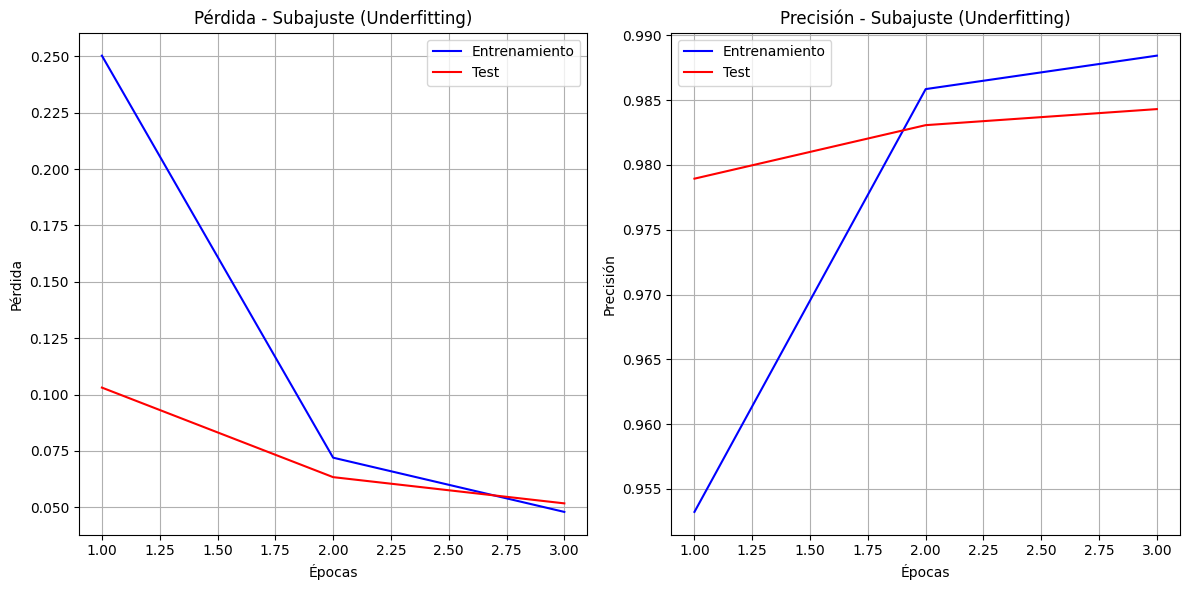

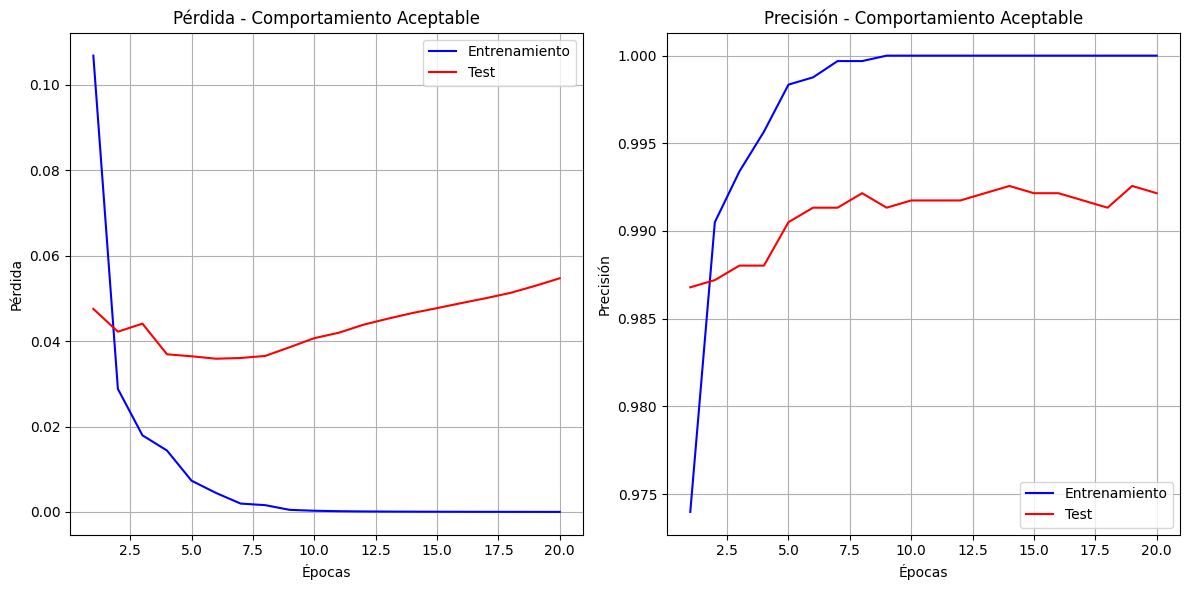

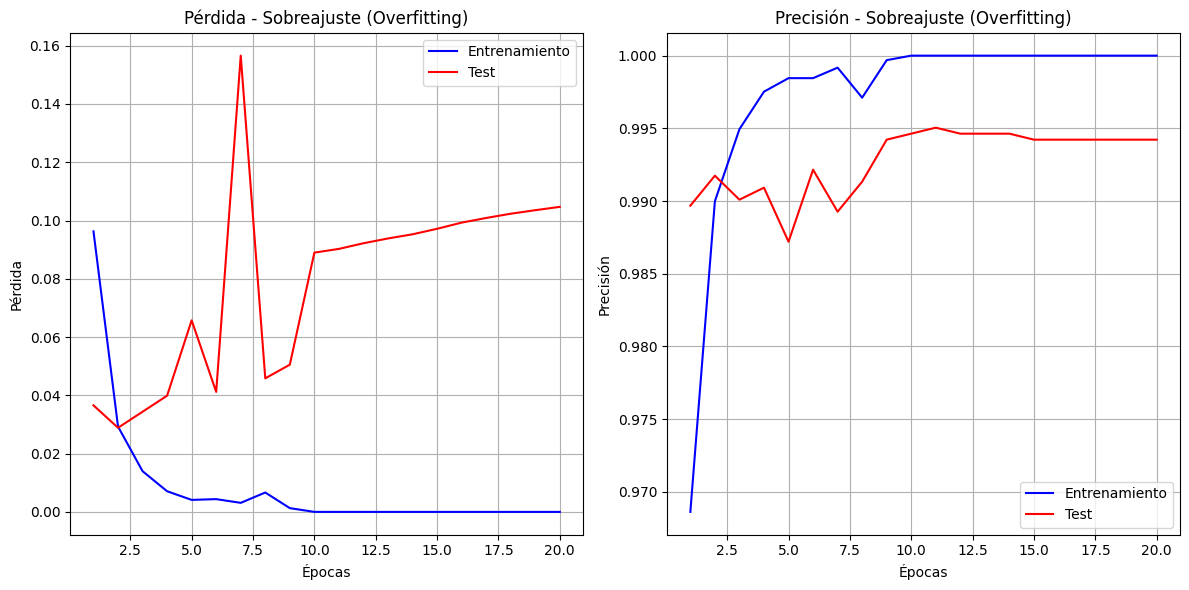

In [16]:
def plot_results(model_name, train_losses, test_losses, train_accuracies, test_accuracies):
  epochs=range(1,len(train_losses)+1)

  plt.figure(figsize=(12, 6))

  #Grafico perdida
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, 'b-', label='Entrenamiento')
  plt.plot(epochs, test_losses, 'r-', label='Test')
  plt.title(f'Pérdida - {model_name}')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.grid(True)

  # Gráfico de la precisión
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accuracies, 'b-', label='Entrenamiento')
  plt.plot(epochs, test_accuracies, 'r-', label='Test')
  plt.title(f'Precisión - {model_name}')
  plt.xlabel('Épocas')
  plt.ylabel('Precisión')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.savefig(f'resultados_{model_name.lower().replace(" ", "_")}.png')
  plt.show()

# Graficar los resultados para cada modelo
plot_results('Subajuste (Underfitting)', *results_underfit)
plot_results('Comportamiento Aceptable', *results_acceptable)
plot_results('Sobreajuste (Overfitting)', *results_overfit)

# Conclusiones

###**Modelo con subajuste**

####**Pérdida:**

La pérdida de entrenamiento y test disminuyen juntas, terminando en valores altos ≈0.05

####**Precisión:**
Ambas precisiones son relativamente bajas a comparacion de los otros modelos y se acercan ≈0.985

###**Modelo aceptable**

####**Pérdida:**
La Pérdida de entrenamiento cae a cero. La Pérdida de eest disminuye y se estabiliza en un valor muy bajo ≈0.05


####**Precisión:** La precision en el entrenamiento es perfecta y en el test auumenta y llega a estabilizarse en 0.992, un valor muy alto.


###**Modelo sobreajuste**

####**Pérdida:**
La Pérdida de entrenamiento cae a cero. La Pérdida de test muestra picos de inestabilidad (epoch 7) y finalmente aumenta hasta ≈0.105 al final


####**Precisión:**
La Precisión de entrenamiento es perfecta (≈1.000), mientras que la de test es alta pero establemente inferior (≈0.995).

##**_MODELOS CONCLUSIONES_**

**Subajuste**
  - PERDIDA (≈0.050) - PRESICIÓN (≈0.0.985)

**Aceptable**
  - PERDIDA (≈0.050) - PRESICIÓN (≈0.992)

**Sobreajuste**
  - PERDIDA  (≈0.105) - PRESICIÓN (≈0.995)

El rendimiento de los modelos parece ser muy bueno en los 3 casos, el modelo sobreajustado presenta mayor presicion pero mas perdida a comparacion del modelo aceptable. Finalmente podemos decir que cada modelo cumple con su objetivo.

Nunca habia trabajado con este dataset, lo vi en los videos que nos compartio en las primeras clases y se veia muy interesante.

Creo que los modelos lograron reflejar la consigna. La funcion fue de lo mas complejo, porque tuve que acudir a ejemplos de notebook que nos dio usted como "**Intro-Pytorch-nn-ejemplo-regresión.ipynb**" y material de Pytorch.

Tuve que pelear los modelos porque seguian dando buenos resultados, y termino dandolos igual pero en menor porcentaje que el modelo "aceptable". Investigue que para forzarlo mas a un subajuste podia desactivar ReLu. En este caso llegue a la conclusion despues de preguntas a la IA, que conoce este dataset bastante bien, me comento que las razones por las que este mdoelo tan simple aprende bien, es porque que  reducimos el modelo de 10 clases a 2, lo que es mucho mas simple para clasificar, entonces aunque la red es simple, es suficiente, creo yo que ademas la diferencia grafica de estos dos numeros **7 y 4**, aunqeu no sea alevoza se llega a diferenciar mas a un modelo que tenga que trabajar con las clases 5 y 6 por ejemplo, entonces eso tambien disminuye la dificultad de clasificar del modelo.

# Referencias

A lo largo del trabajo recurri a promts de gemini en google colab, vi las clases relacionadas con estos temas que nos dio y sus nnotebooks incluidos y ademas los recursos de PyTorch, use chatgpt ademas, mas que nada en la funcion de aprendizaje, y tambien para graficos.